In this notebook we will explore classification problem of seperating network traffic flows in categories of benign and bot. Dataset and detailed information on dataset is available at https://www.unb.ca/cic/datasets/ids-2018.html. 

Basic purpose of the notebook is to apply neural network classifier on network security related datasets. 






In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

Reading datafile when bot traffic is observed in network i.e. Friday-02-03-2018

In [35]:
datafile_path = '/content/drive/My Drive/ML_Data/cse-cic-ids2018/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv' 

In [36]:
df = pd.read_csv(datafile_path)

### Data Exploration and cleanup


In [37]:
df.head(10)

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,443,6,02/03/2018 08:47:38,141385,9,7,553,3773.0,202,0,61.444444,87.534438,1460,0,539.000000,655.432936,30597.30523,113.166177,9.425667e+03,1.906912e+04,73403.0,1.0,141385.0,1.767312e+04,2.396532e+04,73403.0,22.0,51417.0,8569.500000,13036.89082,31525.0,1.0,0,0,0,0,192,152,63.655975,49.510203,0,1460,254.470588,474.712955,225352.389700,0,0,1,1,0,0,0,1,0,270.375000,61.444444,539.000000,0,0,0,0,0,0,9,553,7,3773,8192,119,4,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,49684,6,02/03/2018 08:47:38,281,2,1,38,0.0,38,0,19.000000,26.870058,0,0,0.000000,0.000000,135231.31670,10676.156580,1.405000e+02,1.746554e+02,264.0,17.0,281.0,2.810000e+02,0.000000e+00,281.0,281.0,0.0,0.000000,0.00000,0.0,0.0,1,0,0,0,40,20,7117.437722,3558.718861,0,38,19.000000,21.939310,481.333333,0,1,0,0,1,0,0,0,0,25.333333,19.000000,0.000000,0,0,0,0,0,0,2,38,1,0,123,0,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,443,6,02/03/2018 08:47:40,279824,11,15,1086,10527.0,385,0,98.727273,129.392497,1460,0,701.800000,636.314186,41501.08640,92.915547,1.119296e+04,2.437945e+04,112589.0,1.0,279728.0,2.797280e+04,3.616774e+04,112589.0,94.0,258924.0,18494.571430,36356.50372,133669.0,1.0,0,0,0,0,232,312,39.310424,53.605123,0,1460,430.111111,566.234209,320621.179500,0,0,1,1,0,0,0,1,1,446.653846,98.727273,701.800000,0,0,0,0,0,0,11,1086,15,10527,8192,1047,5,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,443,6,02/03/2018 08:47:40,132,2,0,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.00000,15151.515150,1.320000e+02,0.000000e+00,132.0,132.0,132.0,1.320000e+02,0.000000e+00,132.0,132.0,0.0,0.000000,0.00000,0.0,0.0,0,0,0,0,40,0,15151.515150,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,2,0,0,0,256,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,443,6,02/03/2018 08:47:41,274016,9,13,1285,6141.0,517,0,142.777778,183.887722,1460,0,472.384615,611.180489,27100.60726,80.287282,1.304838e+04,2.631163e+04,114077.0,1.0,273946.0,3.424325e+04,3.799657e+04,114077.0,201.0,252994.0,21082.833330,39075.73819,135611.0,1.0,0,0,0,0,192,272,32.844797,47.442485,0,1460,322.869565,497.254764,247262.300400,0,0,1,1,0,0,0,1,1,337.545455,142.777778,472.384615,0,0,0,0,0,0,9,1285,13,6141,8192,1047,5,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
5,443,6,02/03/2018 08:47:41,250,2,0,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.00000,8000.000000,2.500000e+02,0.000000e+00,250.0,250.0,250.0,2.500000e+02,0.000000e+00,250.0,250.0,0.0,0.000000,0.00000,0.0,0.0,0,0,0,0,40,0,8000.000000,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,2,0,0,0,251,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
6,80,6,02/03/2018 08:47:41,5964033,3,1,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.00000,0.670687,1.988011e+06,3.425210e+06,5943084.0,19.0,5964033.0,2.982016e+06,4.187582e+06,5943084.0,20949.0,0.0,0.000000,0.00000,0.0,0.0,0,0,0,0,72,32,0.503015,0.167672,0,0,0.00000

In [38]:
org_shape = df.shape
print('Original Shape {}'.format(org_shape))

Original Shape (1048575, 80)


In [39]:
# Cleaning up data to remove inf and NaN values from Flow Byts/s and Flow Pkts/s
df.replace([np.inf, -np.inf], np.nan,inplace = True)
df.dropna(inplace = True)

In [40]:
new_shape = df.shape
rows_removed =  org_shape[0] - new_shape[0]
print('New Shape {}'.format(new_shape))
print('Rows deleted {:d}'.format(rows_removed))

New Shape (1044525, 80)
Rows deleted 4050


Observing class balance of bot and benign classes in dataset

In [41]:
df['Label'].value_counts()/df.shape[0]*100

Benign    72.600847
Bot       27.399153
Name: Label, dtype: float64

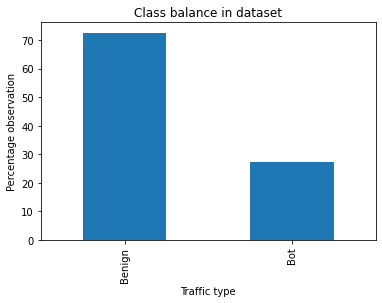

In [42]:
(df['Label'].value_counts()/df.shape[0]*100).plot.bar()
plt.xlabel('Traffic type')
plt.ylabel('Percentage observation')
plt.title('Class balance in dataset')
plt.show()

We have inbalance class in dataset with benign flows 72 per and 27 per bot traffic flow

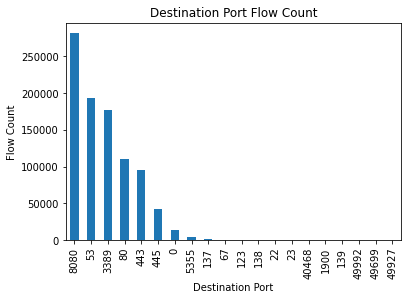


Unique destination ports 37271


In [43]:
df['Dst Port'].value_counts()[:20].plot.bar()
plt.xlabel('Destination Port')
plt.ylabel('Flow Count')
plt.title('Destination Port Flow Count')
plt.show()
print()
print('Unique destination ports {:d}'.format(len(df['Dst Port'].unique())))

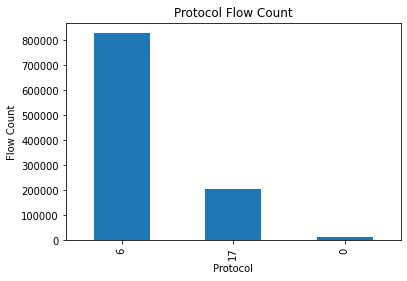


Unique protocol 3


In [44]:
df['Protocol'].value_counts()[:20].plot.bar()
plt.xlabel('Protocol')
plt.ylabel('Flow Count')
plt.title('Protocol Flow Count')
plt.show()
print()
print('Unique protocol {:d}'.format(len(df['Protocol'].unique())))

In [45]:
df.describe()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1044525.0,1044525.0,1044525.0,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1044525.0,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1044525.0,1044525.0,1044525.0,1044525.0,1044525.0,1044525.0,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06,1.044525e+06
mean,8.266766e+03,8.057796e+00,1.155885e+07,5.902530e+00,7.010040e+00,3.935511e+02,5.291713e+03,2.111953e+02,8.273807e+00,5.479855e+01,7.823176e+01,3.484667e+02,1.949306e+01,1.031946e+02,1.261981e+02,1.958319e+05,1.985327e+04,4.276349e+06,7.104750e+05,6.350269e+06,3.955207e+06,1.128562e+07,4.514645e+06,7.706199e+05,6.173834e+06,4.035103e+06,6.307141e+06,5.372406e+05,6.376105e+05,1.921421e+06,1.281696e+05,2.912999e-02,0.0,0.0,0.0,1.240785e+02,1.450918e+02,1.742885e+04,2.424421e+03,8.135052e+00,3.818130e+02,7.436688e+01,1.154662e+02,3.608222e+04,3.355592e-03,2.912999e-02,2.654355e-01,4.588985e-01,3.322831e-01,3.047222e-02,0.0,2.654364e-01,4.812341e-01,8.406810e+01,5.479855e+01,1.031946e+02,0.0,0.0,0.0,0.0,0.0,0.0,5.902530e+00,3.935511e+02,7.010040e+00,5.291538e+03,6.946447e+03,1.127910e+04,2.052119e+00,1.744416e+01,1.234346e+05,6.154744e+04,1.912618e+05,8.337649e+04,4.799736e+06,1.068351e+05,4.882636e+06,4.695151e+06
std,1.496231e+04,4.439372e+00,3.017092e+07,8.920527e+01,2.133700e+02,2.163833e+03,3.094749e+05,2.671786e+02,2.098046e+01,5.765815e+01,9.701599e+01,5.042396e+02,4.553580e+01,1.662110e+02,1.950849e+02,3.081872e+06,1.720986e+05,1.680574e+07,2.978755e+06,1.899792e+07,1.681243e+07,3.005487e+07,1.687808e+07,3.380230e+06,1.886027e+07,1.688556e+07,2.353235e+07,2.608238e+06,2.727316e+06,8.417121e+06,2.051691e+06,1.681709e-01,0.0,0.0,0.0,3.909482e+03,4.249834e+03,1.624415e+05,3.846068e+04,1.927289e+01,4.961310e+02,1.078728e+02,1.508304e+02,7.510190e+04,5.783023e-02,1.681709e-01,4.415650e-01,4.983080e-01,4.710321e-01,1.718828e-01,0.0,4.415655e-01,8.305182e-01,1.119633e+02,5.765815e+01,1.662110e+02,0.0,0.0,0.0,0.0,0.0,0.0,8.920527e+01,2.163833e+03,2.133700e+02,3.093639e+05,1.274966e+04,2.370387e+04,1.395102e+01,5.187126e+00,2.087119e+06,1.264132e+06,2.766778e+06,1.763232e+06,1.744425e+07,1.465423e+06,1.759949e+07,1.736415e+07
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,

### Neural Network to detect Bot
Designing neural network for classification of bot traffic


---



Splitting data in train, validation and test set






In [46]:
#Removing timestamp column from feature list and shuffling dataset
df_temp = df.drop(['Timestamp'],axis = 1, inplace = False).sample(frac=1).reset_index(drop = True)
#Replacing categorical target values with nominal values
df_temp['Label'].replace(['Benign','Bot'],[0,1],inplace = True)
#Creating X and y dataset for further splitting
X = df_temp[df_temp.columns[:-1]]
y = df_temp[df_temp.columns[-1]]
#Dataset splitting
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size = 0.4,train_size = 0.6,stratify=y)
X_val, X_test, y_val,y_test = train_test_split(X_test_val,y_test_val,test_size = 0.5,train_size = 0.5,stratify=y_test_val)

Normalizing data for feeding into neural network



In [47]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Neural network model

In [48]:
model = Sequential()
model.add(Dense(12,input_dim = len(X_train.columns), activation = 'relu'))
model.add(Dense(8,activation ='relu'))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [49]:
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 1.0:
            self.model.stop_training = True

In [50]:
history = model.fit(X_train_scaled,y_train,epochs=10, validation_data=(X_val_scaled,y_val),batch_size=128,callbacks=[CustomCallback()])

Epoch 1/10
4897/4897 [==============================] - 7s 1ms/step - loss: 0.0470 - accuracy: 0.9832 - val_loss: 0.0045 - val_accuracy: 0.9989
Epoch 2/10
4897/4897 [==============================] - 7s 1ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0030 - val_accuracy: 0.9996
Epoch 3/10
4897/4897 [==============================] - 6s 1ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.0027 - val_accuracy: 0.9997
Epoch 4/10
4897/4897 [==============================] - 7s 1ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.0030 - val_accuracy: 0.9997
Epoch 5/10
4897/4897 [==============================] - 6s 1ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.0030 - val_accuracy: 0.9998
Epoch 6/10
4897/4897 [==============================] - 7s 1ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 0.0034 - val_accuracy: 0.9998
Epoch 7/10
4897/4897 [==============================] - 7s 1ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.0034 - val_accuracy:

In [51]:
model.save("/content/drive/My Drive/ML_Data/cse-cic-ids2018/CSE-CIC-IDS201_model.h5")

In [52]:
model = load_model("/content/drive/My Drive/ML_Data/cse-cic-ids2018/CSE-CIC-IDS201_model.h5")

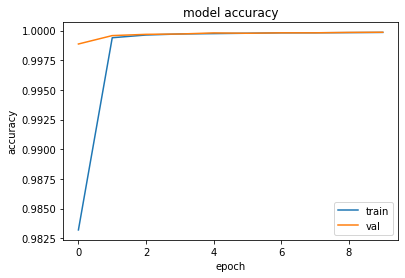

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

model accuracy does not change much after 4 epoch

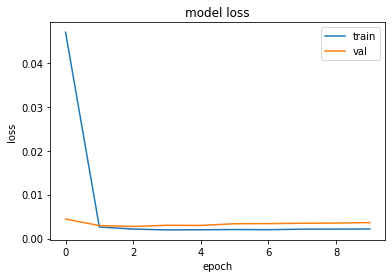

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

model loss remains same in later epochs and training could have been stopped once loss and accuracy stabilize

Evaluating model on validation dataset

In [55]:
_, accuracy = model.evaluate(X_val_scaled,y_val)
print('Accuracy: %.2f' % (accuracy*100))

6529/6529 [==============================] - 5s 833us/step - loss: 0.0036 - accuracy: 0.9999
Accuracy: 99.99


In [56]:
def predict_class(y_probs, threshold):
  y_predict = np.copy(y_probs)
  y_predict[y_predict >= threshold] = 1
  y_predict[y_predict <  threshold] = 0
  y_predict = y_predict.astype(int)
  return y_predict

In [57]:
y_probs = model.predict(X_val_scaled)

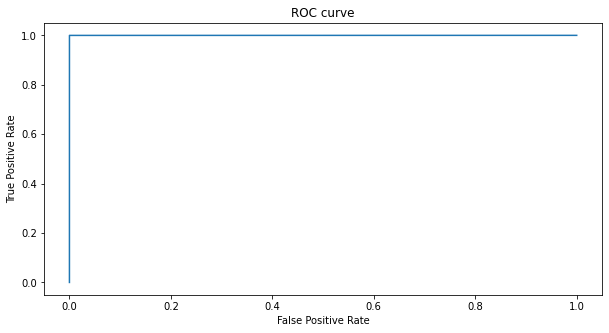

In [58]:
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
plt.figure(figsize = (10,5))
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

RoC curve looks pretty good with maximum area under curve

Evaluating classification model paramaters at different level of threshold. Any attack traffic marked as benign may cause considerable damage to the network so it is better to chose a classification threshold value that reduces false positive in network. This means chosing threshold which leads to higher value of precision

In [59]:
threshold_step = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
df_result = pd.DataFrame(columns = ['Threshold','F1','RoC','Precision','Recall'])
f1 = []
for i in range(len(threshold_step)):
  y_hat = predict_class(y_probs,threshold_step[i])
  f1 = round(f1_score(y_val, y_hat),4)
  r = round(roc_auc_score(y_val,y_hat),4)
  precision = precision_score(y_val, y_hat)
  recall = recall_score(y_val, y_hat)
  df_result = df_result.append({'Threshold':threshold_step[i],'F1':f1,'RoC':r,'Precision':precision,'Recall':recall},ignore_index=True)

In [60]:
df_result

,Threshold,F1,RoC,Precision,Recall
0,0.0,0.4301,0.5000,0.273991,1.000000
1,0.1,0.9997,0.9998,0.999528,0.999808
2,0.2,0.9997,0.9998,0.999633,0.999808
3,0.3,0.9997,0.9998,0.999633,0.999808
4,0.4,0.9997,0.9998,0.999668,0.999808
5,0.5,0.9997,0.9998,0.999668,0.999808
6,0.6,0.9997,0.9998,0.999668,0.999808
7,0.7,0.9997,0.9998,0.999686,0.999808
8,0.8,0.9998,0.9999,0.999720,0.999808
9,0.9,0.9998,0.9999,0.999773,0.999808


Threshold of 0.9 gives higher higest value of precision. Let's compare confusion matrix with threshold value of 0.5 and threshold value of 0.9

<Figure size 360x576 with 0 Axes>

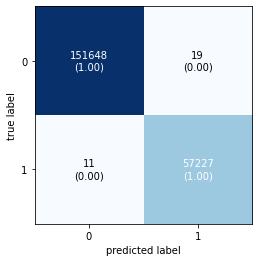

In [61]:
y_hat = predict_class(y_probs,0.5)
results = confusion_matrix(y_val, y_hat)
plt.figure(figsize=(5,8))
class_names = ['Begnin', 'bot']
plot_confusion_matrix(conf_mat=results,show_normed=True)
plt.show()

<Figure size 360x576 with 0 Axes>

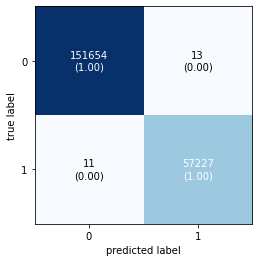

In [62]:
y_hat = predict_class(y_probs,0.9)
results = confusion_matrix(y_val, y_hat)
plt.figure(figsize=(5,8))
class_names = ['Begnin', 'bot']
plot_confusion_matrix(conf_mat=results,show_normed=True)
plt.show()

As threshold value of 0.9 have higher precision thus false positives are capped at 11



### Apply classification model on test data

In [67]:
y_probs = model.predict(X_test_scaled)

In [68]:
_, accuracy = model.evaluate(X_test_scaled,y_test)
print('Accuracy: %.2f' % (accuracy*100))

6529/6529 [==============================] - 6s 851us/step - loss: 0.0028 - accuracy: 0.9999
Accuracy: 99.99


<Figure size 360x576 with 0 Axes>

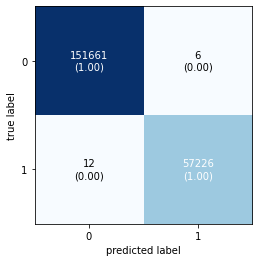

In [69]:
y_hat = predict_class(y_probs,0.9)
results = confusion_matrix(y_test, y_hat)
plt.figure(figsize=(5,8))
class_names = ['Begnin', 'bot']
plot_confusion_matrix(conf_mat=results,show_normed=True)
plt.show()